## CONTEXTO

Este estudo de caso tem como objetivo construir um modelo de regressão para prever o preço de imóveis com base em características como área, número de quartos, mobília e proximidade da via principal. Apesar do conjunto de dados ser pequeno, o desafio está na forte multicolinearidade entre as variáveis, que pode afetar a precisão e interpretação do modelo. O foco será explorar os dados, identificar e tratar essa multicolinearidade, e desenvolver um modelo preditivo eficiente e interpretável.

In [1]:
# Carregando pacotes
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')
from utils import iqr

In [2]:
# Importando os dados
df_housing = pd.read_csv('../Data/raw/Housing.csv')

In [3]:
df_housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [4]:
df_housing.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'],
      dtype='object')

## Dicionario de dados 

| Variável               | Tradução      | Descrição                                      |
|------------------------|-------------|------------------------------------------------|
| price                   | Preço    | Preço das Casas       |
| area               | área   | área da casa                          |
| bedrooms              | quartos  | Quantidade de quartos    |
| bathrooms | banheiros  | Quantidade de banheiros |
| stories                | Andares   | Número de Andares                |
| mainroad                | Estrada Principal    | Casa conectada a uma estrada principal ?                |
| guestroom                | Quarto de Hóspedes    | Possui quarto de hóspedes ?                |
| basement                | Porão   | Possui porão ?                |
| hotwaterheating                | Aquecedor de água quente    | Possui aquecedor de água quente ?                |
| airconditioning                | Ar condicionado    | Possui ar condicionado ?                 |
| parking                | Estacionamento    | Número de vagas de estacionamento              |
| prefarea                | Área Valorizada ?    | Indica se o imóvel está localizado em área valorizada ou desejada                |
| furnishingstatus                | Situação mobiliaria da casa  | Está monbiliada ?             |

In [5]:
# Verificando o tamanho do DataFrame
df_housing.shape


(545, 13)

In [6]:
# Verificando os tipos das variáveis
df_housing.dtypes

price                int64
area                 int64
bedrooms             int64
bathrooms            int64
stories              int64
mainroad            object
guestroom           object
basement            object
hotwaterheating     object
airconditioning     object
parking              int64
prefarea            object
furnishingstatus    object
dtype: object

In [7]:
# Verificando a existência de dados ausentes
df_housing.isnull().sum()/len(df_housing)*100

price               0.0
area                0.0
bedrooms            0.0
bathrooms           0.0
stories             0.0
mainroad            0.0
guestroom           0.0
basement            0.0
hotwaterheating     0.0
airconditioning     0.0
parking             0.0
prefarea            0.0
furnishingstatus    0.0
dtype: float64

In [8]:
df_housing.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


Como o principal foco deste estudo é a variável price - preço das residências, a análise exploratória será direcionada especialmente a ela. A partir deste ponto, buscaremos identificar padrões, relações e possíveis tendências que possam influenciar diretamente os valores dos imóveis.

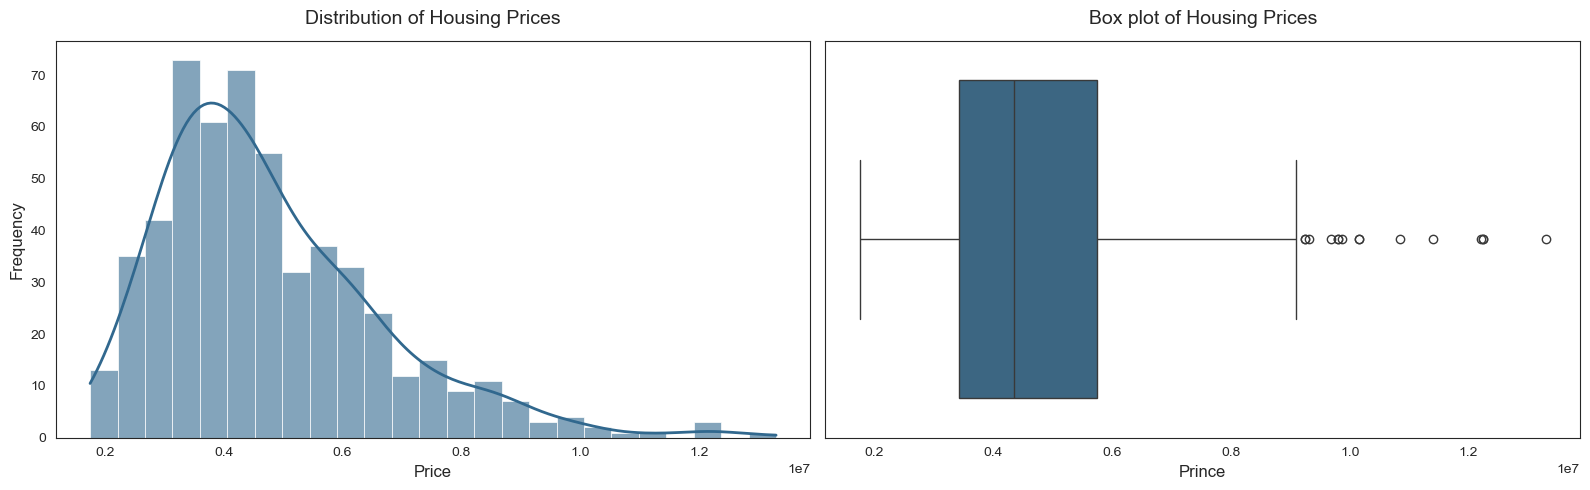

In [9]:
sns.set_style('white')
palette = sns.color_palette("viridis", 2)  
fig, axes = plt.subplots(1,2, figsize=(16,5))

# histograma
hist = sns.histplot(
    df_housing['price'],
    kde=True,
    bins=25,
    ax=axes[0],
    color=palette[0],          
    alpha=0.6,
    edgecolor="white",
    linewidth=0.5,
    line_kws={"linewidth": 2, "color": palette[1]},
    
)
axes[0].set_xlabel("Price", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)
axes[0].set_title("Distribution of Housing Prices", fontsize=14, pad=12)

box_plot = sns.boxplot(
    x=df_housing['price'],
    color=palette[0],
    ax=axes[1]
)

axes[1].set_title('Box plot of Housing Prices', fontsize=14, pad=12)
axes[1].set_xlabel('Prince', fontsize=12)


plt.tight_layout()
plt.show()

Pelos gráficos gerados acima, nota-se que a variável price que representa o preço dos imóveis apresenta uma distribuição assimétrica à direita, logo a maior parte dos dados está concentrada à esquerda da distribuição com calda longa estendendo-se à direita.
 - A faixa de preço com maior frequência está entre aproximadamente 3 e 4,5 milhores, indicando que essa é faixa mais comum para valores de imóveis no respectivo dataset
 - Existe a presença de valores outliers, valores que podem indicar residências de alto padrão ou alta classificação

In [19]:
# Top 15 residências mais caras
sup, inf = iqr(df_housing, 'price')
df_housing[df_housing['price'] > sup]

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
5,10850000,7500,3,3,1,yes,no,yes,no,yes,2,yes,semi-furnished
6,10150000,8580,4,3,4,yes,no,no,no,yes,2,yes,semi-furnished
7,10150000,16200,5,3,2,yes,no,no,no,no,0,no,unfurnished
8,9870000,8100,4,1,2,yes,yes,yes,no,yes,2,yes,furnished
9,9800000,5750,3,2,4,yes,yes,no,no,yes,1,yes,unfurnished


## Verificando a relação entre o preço e outras variáveis


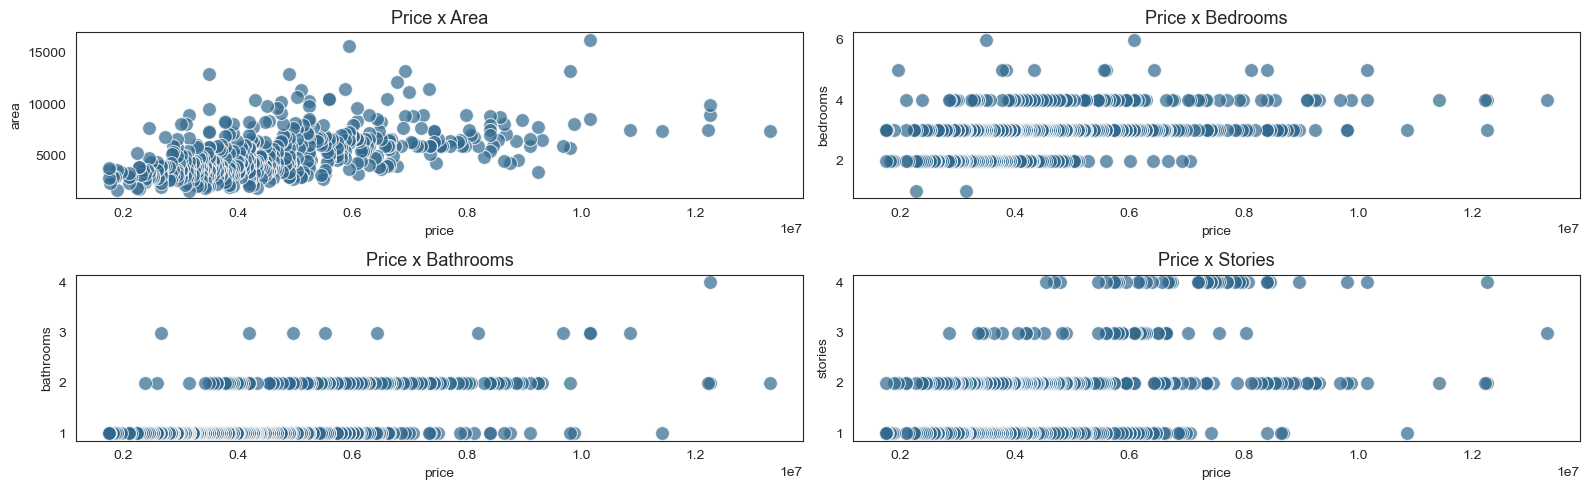

In [11]:
sns.set_style('white')
palette = sns.color_palette("viridis", 2)  
fig,axes = plt.subplots(2,2, figsize=(16,5))

# price x area
sns.scatterplot(x='price', y='area', data=df_housing, s=100, alpha=0.7, ax=axes[0,0], color=palette[0])
axes[0,0].set_title('Price x Area', fontsize=13)

# price x bedrooms
sns.scatterplot(x='price', y='bedrooms', data=df_housing, s=100, alpha=0.7, ax=axes[0,1], color=palette[0])
axes[0,1].set_title('Price x Bedrooms', fontsize=13)

# price x bathrooms
sns.scatterplot(x='price', y='bathrooms', data=df_housing, s=100, alpha=0.7, ax=axes[1,0], color=palette[0])
axes[1,0].set_title('Price x Bathrooms', fontsize=13)

# price x stories
sns.scatterplot(x='price', y='stories', data=df_housing, s=100, alpha=0.7 ,ax=axes[1,1], color=palette[0])
axes[1,1].set_title('Price x Stories', fontsize=13)

plt.tight_layout()
plt.show()

Gráficos:
- Preço x Área: nota-se um padrão ascendente, logo conforme a área aumenta o preço tende a subir.
- Preço x Bathrooms / Bedrooms / Stories: os gráficos se mostram dispersos, sem uma tendência linear clara.

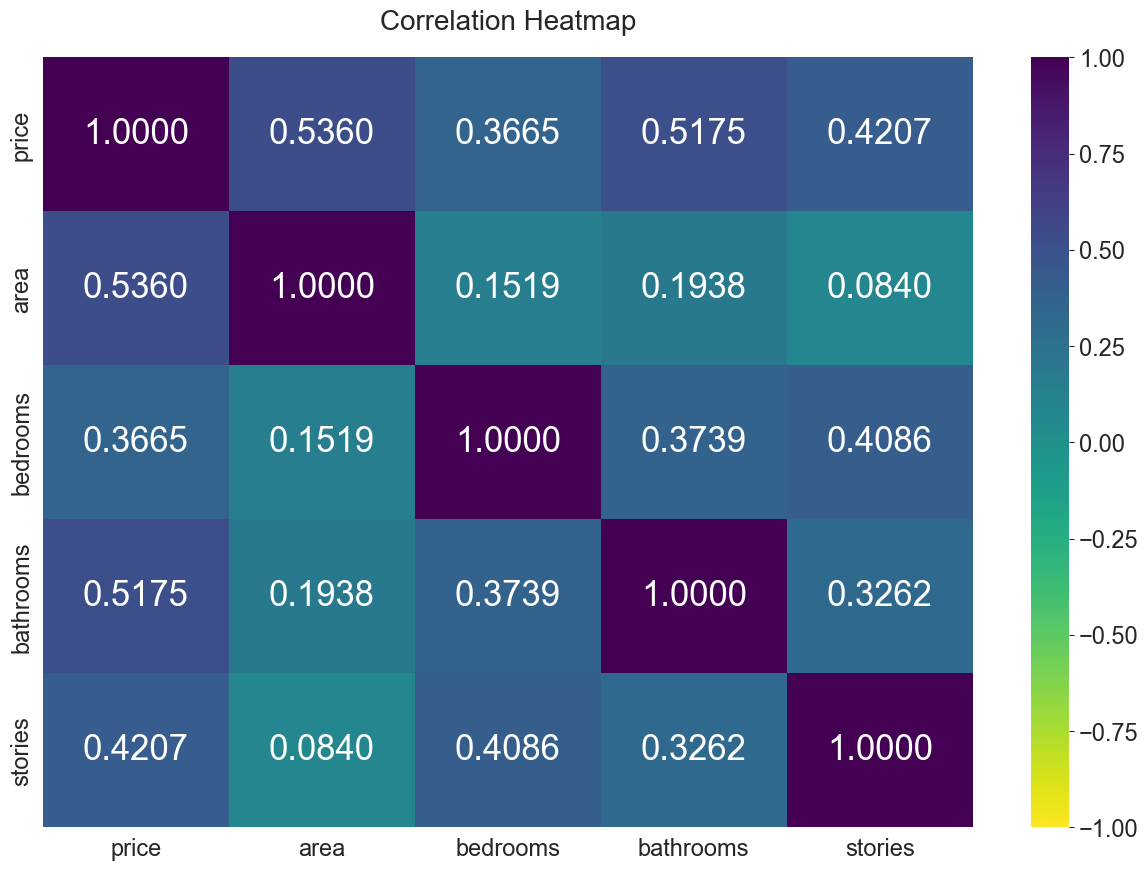

In [25]:
# Correlação entre todas as variáveis quantitativas
correlation_matrix = df_housing[['price', 'area', 'bedrooms', 'bathrooms', 'stories']].corr()


plt.figure(figsize=(15,10))
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".4f",
                      cmap=plt.cm.viridis_r,
                      annot_kws={'size': 25}, vmax=1, vmin=-1)

heatmap.set_title('Correlation Heatmap', fontsize=20, pad=20)
heatmap.set_xticklabels(heatmap.get_xticklabels(),fontsize=17)
heatmap.set_yticklabels(heatmap.get_yticklabels(),fontsize=17)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=17)
plt.show()